In [1]:
from pyspark.sql import SparkSession
import xG_preprocessing as pp
from xG_training import ModelTrainer
from xG_evaluation import ModelEvaluation
import time

In [2]:
spark = SparkSession.builder.appName("xG6").getOrCreate()
spark.conf.set("spark.sql.debug.maxToStringFields", 1000)

your 131072x1 screen size is bogus. expect trouble
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/27 17:06:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/27 17:06:03 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


### Preprocessing

In [3]:
events = spark.read.csv('hdfs://localhost:9000/big-data/events.csv',header=True,inferSchema=True,sep=';')

In [2]:
start_time = time.time()
shots = pp.preprocessing(events, spark)
end_time = time.time()

elapsed_time = end_time - start_time
print(f"Preprocessing took {elapsed_time:.2f} seconds.")

Preprocessing took 10310 seconds.


### Reading Data

In [4]:
shots.show()

+--------------------+---------+---------------+---------------+----------------+----------+-------------------+--------+-------+-------+-----------+------------+-------+-----------+-------+------+-----------+-------+-------+---------------------+----------------+-------------+------------------+------------------+------------------+--------------+---------------+---------------+---------------+--------------+--------------------+-------------------+-----------------+------------+----+-------------+
|                  id|player_id|shot_location_x|shot_location_y|distance_to_goal|shot_angle|preferred_foot_shot|other_pp|from_fk|from_ti|from_corner|from_counter|from_gk|from_keeper|from_ko|header|corner_type|fk_type|pk_type|half_volley_technique|volley_technique|lob_technique|overhead_technique|backheel_technique|diving_h_technique|under_pressure|shot_aerial_won|shot_first_time|shot_one_on_one|shot_open_goal|shot_follows_dribble|players_inside_area|shot_statsbomb_xg|shot_outcome|goal|sb_pr

## Model Training

In [5]:
train_data, test_data = pp.pre_training(shots)

## Regression Logistique

### Training

ROC-AUC for max_iter=10: 80.31%
ROC-AUC for max_iter=20: 80.41%
ROC-AUC for max_iter=30: 80.41%
ROC-AUC for max_iter=40: 80.41%
ROC-AUC for max_iter=50: 80.41%
ROC-AUC for max_iter=60: 80.41%
ROC-AUC for max_iter=70: 80.41%
ROC-AUC for max_iter=80: 80.41%
ROC-AUC for max_iter=90: 80.41%
ROC-AUC for max_iter=100: 80.41%


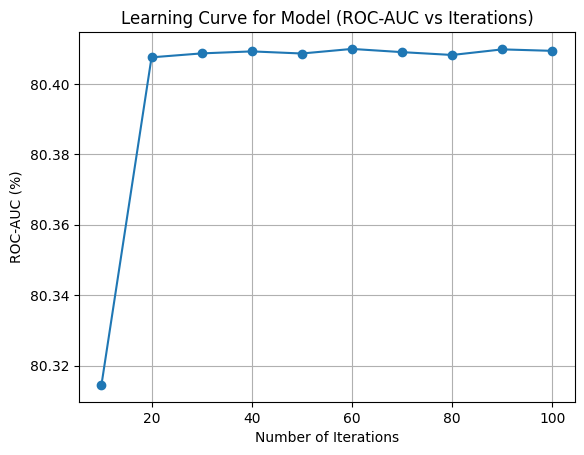

In [7]:
log_reg = ModelTrainer('logistic',train_data,test_data,max_iter=100)
log_reg.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

### Evaluation

In [8]:
predictions = log_reg.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [9]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.05,
 'Precision': 69.13,
 'Recall': 19.93,
 'Sensitivity': 19.93,
 'Specificity': 98.88,
 'F1': 30.94,
 'FPR': 1.12,
 'FNR': 80.07}

In [10]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.64,
 'Precision': 82.91,
 'Recall': 76.83,
 'Sensitivity': 76.83,
 'Specificity': 99.43,
 'F1': 79.75,
 'FPR': 0.57,
 'FNR': 23.17}

In [11]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00367, 'RMSE': 0.06054, 'MAE': 0.03412, 'R2': 83.02}

In [ ]:
log_reg = ModelTrainer('logistic',train_data,train_data,max_iter=100)

In [18]:
predictions = log_reg.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [20]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.56,
 'Precision': 68.14,
 'Recall': 22.15,
 'Sensitivity': 22.15,
 'Specificity': 98.76,
 'F1': 33.43,
 'FPR': 1.24,
 'FNR': 77.85}

In [21]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.67,
 'Precision': 84.01,
 'Recall': 79.05,
 'Sensitivity': 79.05,
 'Specificity': 99.42,
 'F1': 81.45,
 'FPR': 0.58,
 'FNR': 20.95}

In [22]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00385, 'RMSE': 0.06203, 'MAE': 0.03482, 'R2': 82.89}

## Random Forest

In [ ]:
rf = ModelTrainer('rf',train_data,test_data,max_iter=100)

ROC-AUC for max_iter=10: 78.27%
ROC-AUC for max_iter=20: 78.27%
ROC-AUC for max_iter=30: 78.30%
ROC-AUC for max_iter=40: 78.27%
ROC-AUC for max_iter=50: 78.30%
ROC-AUC for max_iter=60: 78.27%
ROC-AUC for max_iter=70: 78.30%
ROC-AUC for max_iter=80: 78.27%
ROC-AUC for max_iter=90: 78.30%
ROC-AUC for max_iter=100: 78.27%


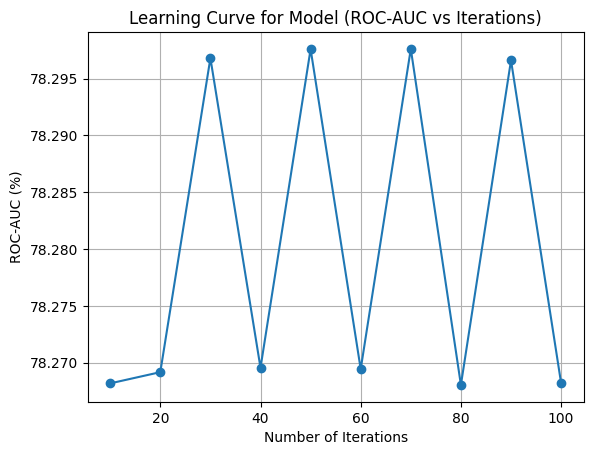

In [13]:
rf.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [23]:
predictions = rf.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.05,
 'Precision': 79.76,
 'Recall': 14.78,
 'Sensitivity': 14.78,
 'Specificity': 99.53,
 'F1': 24.94,
 'FPR': 0.47,
 'FNR': 85.22}

In [24]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.4,
 'Precision': 95.24,
 'Recall': 56.74,
 'Sensitivity': 56.74,
 'Specificity': 99.9,
 'F1': 71.11,
 'FPR': 0.1,
 'FNR': 43.26}

In [25]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00681, 'RMSE': 0.08253, 'MAE': 0.05332, 'R2': 68.46}

In [ ]:
rf = ModelTrainer('rf',train_data,train_data,max_iter=100)

In [27]:
predictions = rf.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.68,
 'Precision': 80.92,
 'Recall': 16.92,
 'Sensitivity': 16.92,
 'Specificity': 99.52,
 'F1': 27.98,
 'FPR': 0.48,
 'FNR': 83.08}

In [28]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.36,
 'Precision': 96.02,
 'Recall': 58.1,
 'Sensitivity': 58.1,
 'Specificity': 99.91,
 'F1': 72.39,
 'FPR': 0.09,
 'FNR': 41.9}

In [29]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00698, 'RMSE': 0.08352, 'MAE': 0.05373, 'R2': 68.98}

## Gradient Boosted Trees

In [ ]:
gbt = ModelTrainer('gbt',train_data,test_data,max_iter=60)

ROC-AUC for max_iter=10: 80.73%
ROC-AUC for max_iter=20: 81.01%
ROC-AUC for max_iter=30: 81.15%
ROC-AUC for max_iter=40: 81.25%
ROC-AUC for max_iter=50: 81.25%
ROC-AUC for max_iter=60: 81.29%
ROC-AUC for max_iter=70: 81.29%
ROC-AUC for max_iter=80: 81.27%
ROC-AUC for max_iter=90: 81.22%
ROC-AUC for max_iter=100: 81.21%


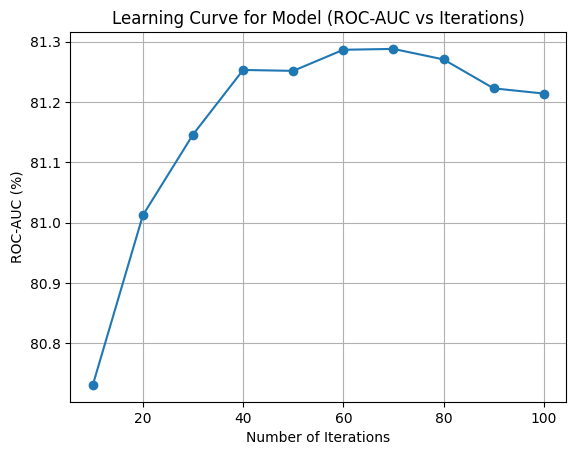

In [31]:
gbt.plot_learning_curve(max_iter_range=[10,20,30,40,50,60,70,80,90,100])

In [32]:
predictions = gbt.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')

In [33]:
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.15,
 'Precision': 70.74,
 'Recall': 20.44,
 'Sensitivity': 20.44,
 'Specificity': 98.93,
 'F1': 31.72,
 'FPR': 1.07,
 'FNR': 79.56}

In [34]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.42,
 'Precision': 79.39,
 'Recall': 73.76,
 'Sensitivity': 73.76,
 'Specificity': 99.31,
 'F1': 76.47,
 'FPR': 0.69,
 'FNR': 26.24}

In [35]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00376, 'RMSE': 0.06134, 'MAE': 0.03133, 'R2': 82.58}

In [ ]:
gbt = ModelTrainer('logistic',train_data,train_data,max_iter=60)

In [38]:
predictions = gbt.predictions
predictions = pp.goal_proba(predictions)
me = ModelEvaluation(predictions,'goal','prediction')
me_sb = ModelEvaluation(predictions,'sb_prediction','prediction')
me_r = ModelEvaluation(predictions,'shot_statsbomb_xg','goal_probability',model_type='regression')
print('Real World Classification results')
me.get_all_metrics()

Real World Classification results


{'Accuracy': 90.56,
 'Precision': 68.14,
 'Recall': 22.15,
 'Sensitivity': 22.15,
 'Specificity': 98.76,
 'F1': 33.43,
 'FPR': 1.24,
 'FNR': 77.85}

In [40]:
print('Classification results compared to StatsBomb Model')
me_sb.get_all_metrics()

Classification results compared to StatsBomb Model


{'Accuracy': 98.67,
 'Precision': 84.01,
 'Recall': 79.05,
 'Sensitivity': 79.05,
 'Specificity': 99.42,
 'F1': 81.45,
 'FPR': 0.58,
 'FNR': 20.95}

In [41]:
print('Regression results')
me_r.get_all_metrics()

Regression results


{'MSE': 0.00385, 'RMSE': 0.06203, 'MAE': 0.03482, 'R2': 82.89}

In [19]:
spark.stop()